<!--
 * @Author: TMJ
 * @Date: 2024-03-08 21:11:46
 * @LastEditors: TMJ
 * @LastEditTime: 2024-03-08 21:19:40
 * @Description: 请填写简介
-->
# 结构复原基准测试

从坐标文件中恢复分子拓扑结构是一个非常实际的需要。许多化学信息学家使用桌面软件，如高斯视图可视化实时恢复分子拓扑结构和调整可疑的键合关系。这种方法可以使分子结构正如化学家所知道的那样，但不幸的是，它需要大量的人力参与！当试图从现有的量子化学计算或坐标文件构建分子数据集时，对自动化工具的需求正在上升。

流行的开源化学信息学工具 OpenBabel 和 RDKit 都提供了从坐标文件恢复分子拓扑结构的能力，但不幸的是，它们都遇到了一些致命的问题。这些问题使我不可能继续我的化学数据库建设项目，所以我决定创建一个新的项目，以学习他们的优势和克服他们的问题-MolOP 就是为此目的而诞生的！

|     functions     | OpenBabel | RDKit | MolOP |
| :---------------: | :-------: | :---: | :---: |
| Neutral Molecule  |     😏     |   😏   |   😏   |
| Charge processing |     😰     |   😏   |   😏   |
| Metel processing  |     😏     |   😰   |   😏   |


更详细地说，OpenBabel 和 RDKit 都有一些无法处理的分子类型。不幸的是，这些分子在我的数据集中非常常见，所以 MolOP 对它们进行了有针对性的优化。


|              target molecule              |               example                | OpenBabel | RDKit | MolOP |
| :---------------------------------------: | :----------------------------------: | :-------: | :---: | :---: |
|          simple organic molecule          |              `c1ccccc1`              |     😏     |   😏   |   😏   |
|       under-bonded organic molecule       |               `[CH3]`                |     😏     |   😰   |   😏   |
| under-bonded organic molecule with charge |               `[CH3-]`               |     😰     |   😏   |   😏   |
| under-bonded organic molecule with charge |            `c1cccc[c+]1`             |     😰     |   😰   |   😏   |
| under-bonded organic molecule with charge |            `c1cccc[c-]1`             |     😰     |   😏   |   😏   |
|       over-bonded organic molecule        |               `[NH4+]`               |     😰     |   😏   |   😏   |
|                  Dipole                   |           `C[N+](-[O-])=O`           |     😏     |   😏   |   😏   |
|                  Dipole                   |             `C[N+]#[C-]`             |     😰     |   😏   |   😏   |
|                  Dipole                   |            `C=[N+]=[N-]`             |     😰     |   😏   |   😏   |
|                   Ylide                   | `c1ccccc1-P(-c1ccccc1)(-c1ccccc1)=C` |     😰     |   😏   |   😏   |
|                Inner salt                 |        `[O-]C(=O)CCCC[NH3+]`         |     😰     |   😏   |   😏   |
|               Metal complex               |                 ...                  |     😰     |   😰   |   😏   |

In [54]:
from molop.structure.structure_recovery import xyz_block_to_omol
from openbabel import pybel
from rdkit import Chem
from rdkit.Chem import AllChem, rdDetermineBonds

from molop import AutoParser


def smi2xyz(smi: str):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    return Chem.MolToXYZBlock(mol)

## 单有机分子

In [55]:
xyz_block = smi2xyz("c1ccccc1")
print(xyz_block)

12

C     -0.026752   -1.365451    0.048272
C     -1.238026   -0.674225    0.022380
C     -1.161393    0.702995   -0.026249
C      0.040545    1.373448   -0.048539
C      1.224212    0.667467   -0.022156
C      1.181967   -0.730682    0.027253
H     -0.111562   -2.442496    0.086275
H     -2.177358   -1.209365    0.040194
H     -2.069317    1.287660   -0.048013
H      0.077425    2.448675   -0.086533
H      2.155142    1.215510   -0.040438
H      2.105117   -1.273536    0.047554



### OpenBabel 😏

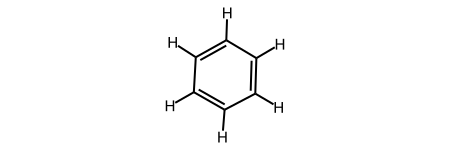

In [56]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

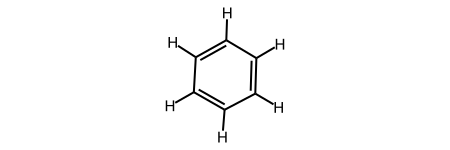

In [57]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

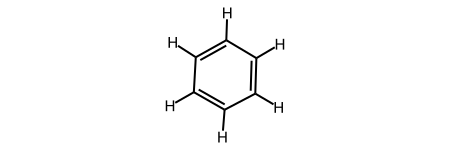

In [58]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 未键合的有机分子 (e.g. `[CH3]`)

In [59]:
xyz_block = smi2xyz("[CH3]")
print(xyz_block)

4

C     -0.006775   -0.009872    0.260733
H      1.003918   -0.301537   -0.086160
H     -0.783623   -0.702200   -0.089493
H     -0.213520    1.013609   -0.085081



### OpenBabel 😏

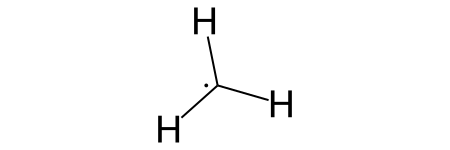

In [60]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😰

Final molecular charge does not match input; could not find valid bond ordering


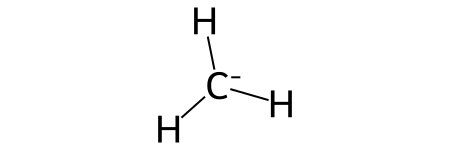

In [61]:
# FAILED
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

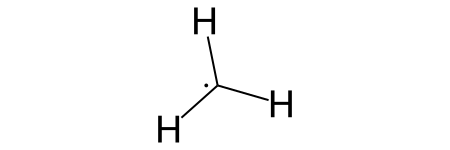

In [62]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 含电荷的未键合的有机分子 (e.g. `[CH3-]`)

In [63]:
xyz_block = smi2xyz("[CH3-]")
print(xyz_block)

4

C     -0.008449   -0.004743    0.266828
H      0.987115   -0.307223   -0.087415
H     -0.770932   -0.713101   -0.091091
H     -0.207734    1.025067   -0.088323



### OpenBabel 😰

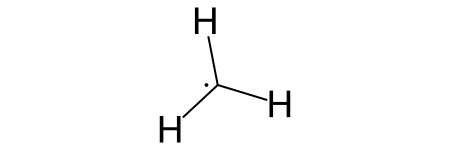

In [64]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

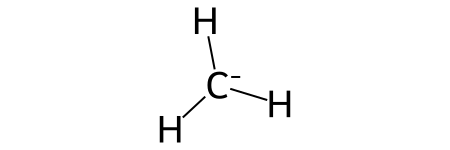

In [65]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=-1)
except Exception as e:
    print(e)
mol

### MolOP 😏

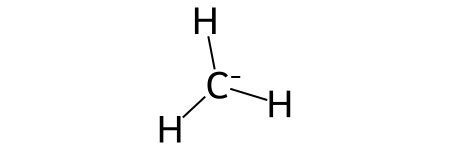

In [66]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=-1).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 含电荷的未键合的有机分子 (e.g. `c1cccc[c+]1`)

In [67]:
xyz_block = smi2xyz("c1cccc[c+]1")
print(xyz_block)

11

C      1.200891   -0.866903   -0.090481
C      1.195903    0.440689    0.093665
C     -0.058423    1.177243    0.164369
C     -1.181506    0.486922    0.037446
C     -1.156233   -0.953557   -0.164893
C     -0.026254   -1.585804   -0.224176
H      2.168624   -1.393846   -0.139212
H      2.159825    0.946336    0.190352
H     -0.064645    2.252597    0.315756
H     -2.134941    1.007653    0.085676
H     -2.103241   -1.511330   -0.268502



### OpenBabel 😰

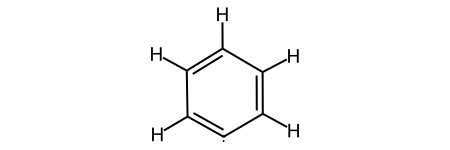

In [68]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😰

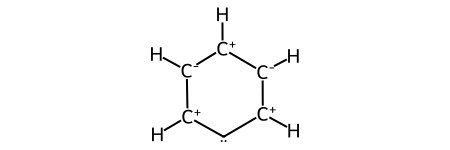

In [69]:
# FAILED
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=1)
except Exception as e:
    print(e)
mol

### MolOP 😏

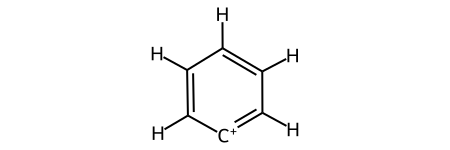

In [70]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=1).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 含电荷的未键合的有机分子 (e.g. `c1cccc[c-]1`)

In [71]:
xyz_block = smi2xyz("c1cccc[c-]1")
print(xyz_block)

11

C      1.080973   -1.004605   -0.054190
C      1.267437    0.361146    0.009319
C      0.125017    1.135248    0.052977
C     -1.127994    0.565501    0.033696
C     -1.306126   -0.800832   -0.029890
C     -0.171039   -1.583374   -0.073903
H      1.993666   -1.605291   -0.088228
H      2.252876    0.817402    0.024866
H      0.219032    2.212673    0.103397
H     -2.042229    1.160019    0.067443
H     -2.291614   -1.257888   -0.045485



### OpenBabel 😰

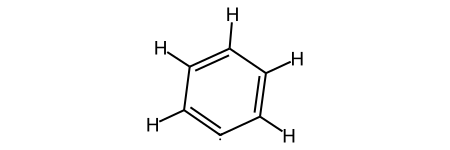

In [72]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

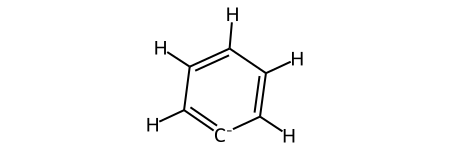

In [73]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=-1)
except Exception as e:
    print(e)
mol

### MolOP 😏

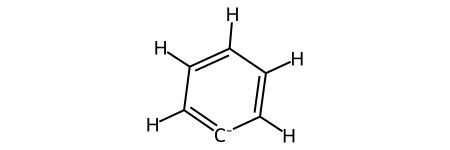

In [74]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=-1).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 过度键合的分子 (e.g. `[NH4+]`)

In [75]:
xyz_block = smi2xyz("[NH4+]")
print(xyz_block)

5

N     -0.024459   -0.005992   -0.004669
H     -0.672537   -0.763175   -0.267706
H     -0.296439    0.928477   -0.357457
H      0.079861    0.057864    1.030101
H      0.913574   -0.217174   -0.400269



### OpenBabel 😰

In [76]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

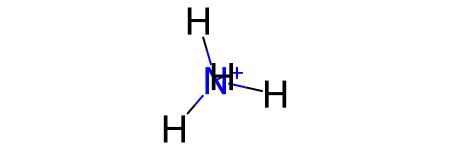

In [77]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=1)
except Exception as e:
    print(e)
mol

### MolOP 😏

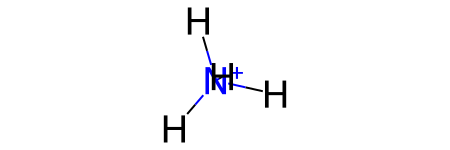

In [78]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=1).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 偶极子 (e.g. `C[N+](-[O-])=O`)

In [79]:
xyz_block = smi2xyz("C[N+](-[O-])=O")
print(xyz_block)

7

C     -0.642678   -0.060986    0.055843
N      0.779019    0.185116   -0.058150
O      1.567391   -0.931486   -0.208262
O      1.309685    1.300880   -0.029643
H     -1.237404    0.840695    0.171512
H     -0.844953   -0.710787    0.948718
H     -0.931061   -0.623431   -0.880017



### OpenBabel 😏

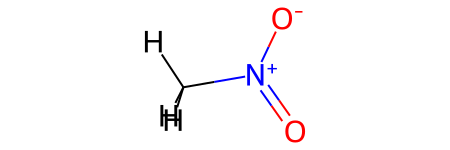

In [80]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

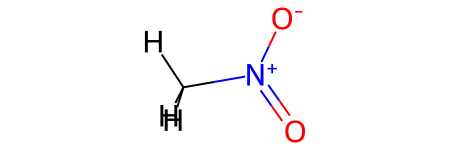

In [81]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

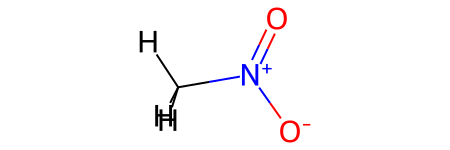

In [82]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 偶极子 (e.g. `C[N+]#[C-]`)

In [83]:
xyz_block = smi2xyz("C[N+]#[C-]")
print(xyz_block)

6

C     -0.459825   -0.024156    0.093481
N      0.903129    0.068193   -0.177392
C      2.048761    0.165842   -0.405285
H     -0.804769   -1.088204   -0.039535
H     -0.676067    0.247017    1.152809
H     -1.011229    0.631308   -0.624079



### OpenBabel 😰

In [84]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

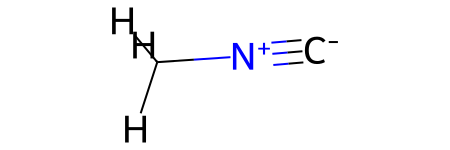

In [85]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

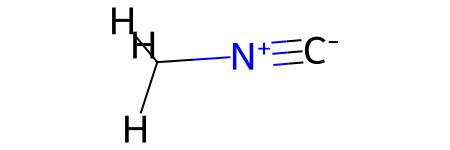

In [86]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 偶极子 (e.g. `C=[N+]=[N-]`)

In [87]:
xyz_block = smi2xyz("C=[N+]=[N-]")
print(xyz_block)

5

C     -0.485083    0.001240   -0.725650
N      0.775369    0.007865   -0.588641
N      1.794963   -0.020584    0.127828
H     -1.032553    0.936373   -0.784482
H     -1.052696   -0.924894   -0.788012



### OpenBabel 😰

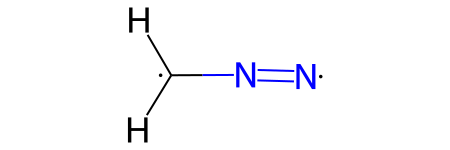

In [88]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

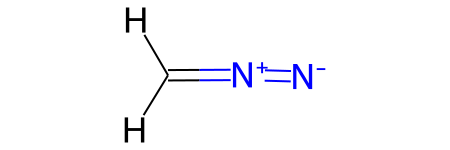

In [89]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

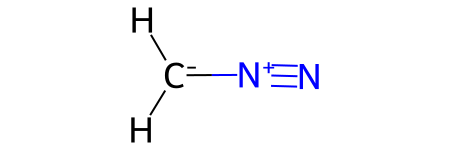

In [90]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 叶立德 (e.g. `c1ccccc1-P(-c1ccccc1)(-c1ccccc1)=C`)

## 

In [91]:
xyz_block = smi2xyz("c1ccccc1-P(-c1ccccc1)(-c1ccccc1)=C")
print(xyz_block)

37

C     -1.636283   -2.163045   -0.873437
C     -2.754699   -2.855802   -0.457806
C     -3.545329   -2.357492    0.569193
C     -3.262870   -1.172226    1.213940
C     -2.138241   -0.477989    0.794242
C     -1.357104   -0.977867   -0.226030
P      0.085466   -0.069240   -0.750978
C     -0.098080    1.678661   -0.516293
C     -0.322492    2.515766   -1.586726
C     -0.471430    3.883443   -1.449162
C     -0.387919    4.411787   -0.173839
C     -0.161946    3.561046    0.895884
C     -0.015896    2.202557    0.742889
C      1.513080   -0.711029    0.089754
C      2.448376    0.115661    0.697531
C      3.535213   -0.473079    1.332990
C      3.701843   -1.842237    1.371984
C      2.776341   -2.669348    0.770157
C      1.684180   -2.074708    0.131721
C      0.300846   -0.354041   -2.354257
H     -1.016977   -2.547572   -1.673577
H     -2.991486   -3.789476   -0.953822
H     -4.419376   -2.904612    0.889753
H     -3.893181   -0.806790    2.009078
H     -1.919736    0.443096    1.296

### OpenBabel 😰

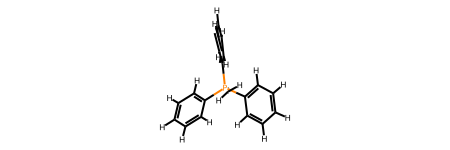

In [92]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

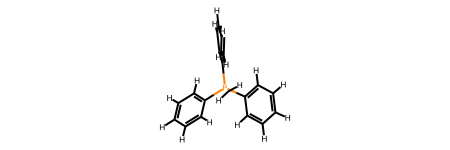

In [93]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

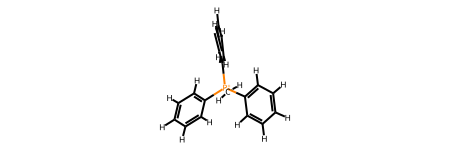

In [94]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 内盐 (e.g. `[O-]C(=O)CCCC[NH3+]`)

In [95]:
xyz_block = smi2xyz("[O-]C(=O)CCCC[NH3+]")
print(xyz_block)

19

O     -3.451490    1.580149    0.292724
C     -2.519413    0.700255   -0.233393
O     -1.979527    1.007678   -1.326673
C     -2.127369   -0.567832    0.410965
C     -0.788348   -0.463530    1.085173
C      0.312847   -0.107203    0.127418
C      1.629478   -0.020877    0.876333
N      2.637893    0.331255   -0.128571
H     -2.139686   -1.350020   -0.384558
H     -2.884589   -0.895955    1.160276
H     -0.539752   -1.445881    1.536213
H     -0.849507    0.330076    1.851883
H      0.458490   -0.891339   -0.650841
H      0.154100    0.855454   -0.390673
H      1.615815    0.773256    1.662770
H      1.903584   -1.014763    1.281813
H      3.472388    0.769803    0.305576
H      2.917381   -0.548280   -0.584473
H      2.177703    0.957754   -0.816728



### OpenBabel 😰

In [96]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😏

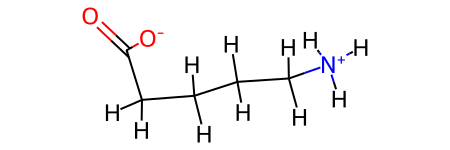

In [97]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

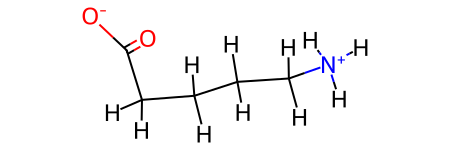

In [98]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

## 金属配合物

In [99]:
xyz_block = AutoParser(
    "../../tests/test_files/g16log/S_Ph_Ni_TS.log",
)[0][-1].to_XYZ_block()
print(xyz_block)

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]
0 files failed to parse, 1 successfully parsed


47
charge 0 multiplicity 1
Ni          -0.73558  -0.16221  -0.03634
Br          -2.32855  -0.22516   1.90079
Br          -2.56176  -0.95050  -1.47321
N           -0.21272  -2.25241   0.03069
C            0.22864  -2.95217  -0.99508
C           -0.47539  -3.13843   1.05220
H            0.47951  -2.54317  -1.96251
C           -0.17596  -4.40734   0.63144
H           -0.88916  -2.78815   1.98547
H            0.53338  -5.02247  -1.29389
H           -0.24682  -5.36904   1.11491
N            0.71192   0.11230   1.26017
C            1.84168  -0.57597   1.25081
C            0.71991   0.91228   2.38943
H            2.14573  -1.27854   0.49750
C            1.89178   0.70751   3.06056
H           -0.12354   1.53742   2.62796
H            3.52804  -0.56314   2.48768
H            2.27620   1.12077   3.97908
N            2.58155  -0.25050   2.33203
N            0.27673  -4.27051  -0.67130
S            0.23475   0.41488  -2.06399
C            1.80086   1.38526  -2.07773
H            2.02370   1.42046

### OpenBabel 😰

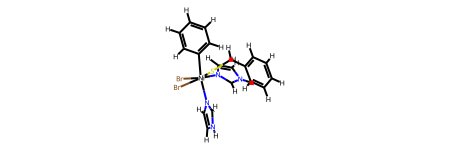

In [100]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False)
except Exception as e:
    print(e)
mol

### RDKit 😰

determineBondOrdering() does not work with element Ni


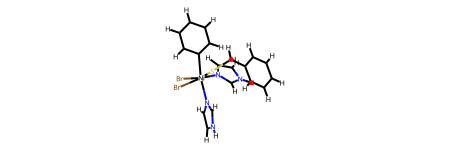

In [101]:
# FAILED
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

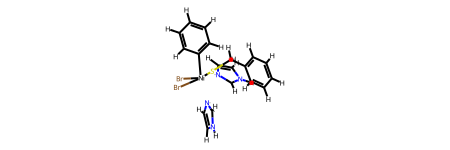

In [102]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        xyz_block_to_omol(xyz_block, given_charge=0).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol